# Análise comparativa de modelos

In [1]:
from IPython.display import Image, display, Markdown
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import joblib

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit, GridSearchCV, KFold, cross_validate
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

colors = ["#9467bd", "#057476", "#FF7A00"]
sns.set_theme(style="ticks")
sns.set_palette(sns.color_palette(colors))

# 1. Obtenção de dados

In [2]:
# Carregar o arquivo dos dados
df = sns.load_dataset("diamonds")
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [3]:
# Carregar o dicionário
dicionario = pd.read_csv("../data/external/dictionary_diamonds.csv")
dicionario

,variavel,descricao,tipo,subtipo
0,carat,Peso do diamante,quantitativa,continua
1,cut,Qualidade do corte,qualitativa,ordinal
2,color,Cor do diamante,qualitativa,ordinal
3,clarity,Pureza do diamante,qualitativa,ordinal
4,depth,Porcentagem de profundidade total,quantitativa,continua
5,table,Largura do topo do losango em relação ao ponto...,quantitativa,continua
6,price,Preço em dólares americanos,quantitativa,discreta
7,x,Comprimento em mm,quantitativa,continua
8,y,Largura em mm,quantitativa,continua
9,z,Profundidade em mm,quantitativa,continua


# 2. Preparação de dados

In [4]:
# Verificar valores missing ou NAM (valores faltantes)
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

Não há dados faltantes neste dataset.

In [5]:
# Separar as variáveis

variavel_alvo = 'price'

coluna_ordinal_cut = (
    dicionario
    .query("variavel in ['cut']")
    .variavel
    .to_list()
)

coluna_ordinal_color = (
    dicionario
    .query("variavel in ['color']")
    .variavel
    .to_list()
)

coluna_ordinal_clarity = (
    dicionario
    .query("variavel in ['clarity']")
    .variavel
    .to_list()
)

colunas_continuas = (
    dicionario
    .query("subtipo == 'continua'")
    .variavel
    .to_list()
)

colunas_quantitativas = (
    dicionario
    .query("tipo == 'quantitativa'")
    .variavel
    .to_list()
)

X = df.drop(columns=[variavel_alvo], axis=1)
y = df[variavel_alvo]

coluna_ordinal_cut, coluna_ordinal_color, coluna_ordinal_clarity, colunas_continuas, colunas_quantitativas

(['cut'],
 ['color'],
 ['clarity'],
 ['carat', 'depth', 'table', 'x', 'y', 'z'],
 ['carat', 'depth', 'table', 'price', 'x', 'y', 'z'])

In [6]:
# Variáveis independente
X.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75


In [7]:
X.shape

(53940, 9)

In [ ]:
# Variável dependente
y

#### - Tratamento dos outliers

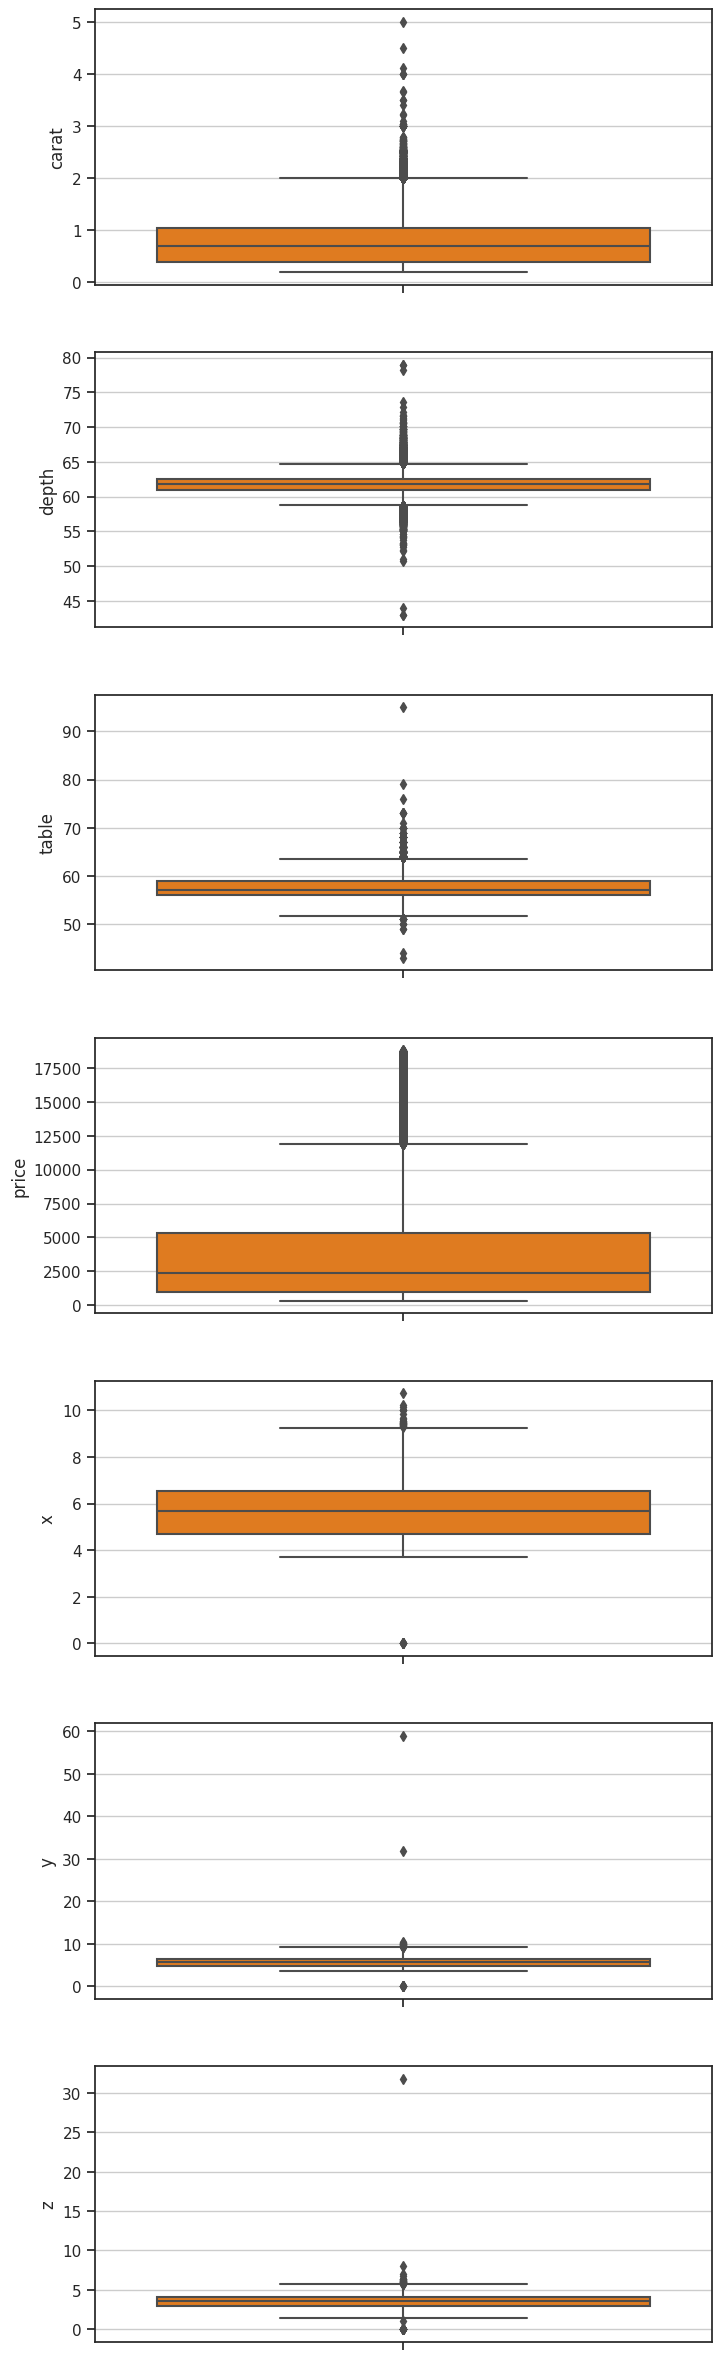

In [10]:
fig, axes = plt.subplots(7, 1, figsize=(8, 25))
plt.tight_layout(pad=4, w_pad=2, h_pad=2)

for i, variavel in enumerate(colunas_quantitativas):
    ax = sns.boxplot(
        y=df[variavel], 
        ax=axes[i],
        color=colors[2]
    ) 
    ax.grid(axis='y', linestyle='-')

plt.show()

In [11]:
z_scores = stats.zscore(df.select_dtypes(include=[float, int]))
abs_z_scores = abs(z_scores)
filtro = (abs_z_scores < 3).all(axis=1)

novo_df = df[filtro]

X = novo_df

y = df[filtro][variavel_alvo]

In [12]:
X.shape

(51590, 10)

In [13]:
y.shape

(51590,)

É possível perceber que após a remoção dos valores outliers, houve uma redução na quantidade de dados.

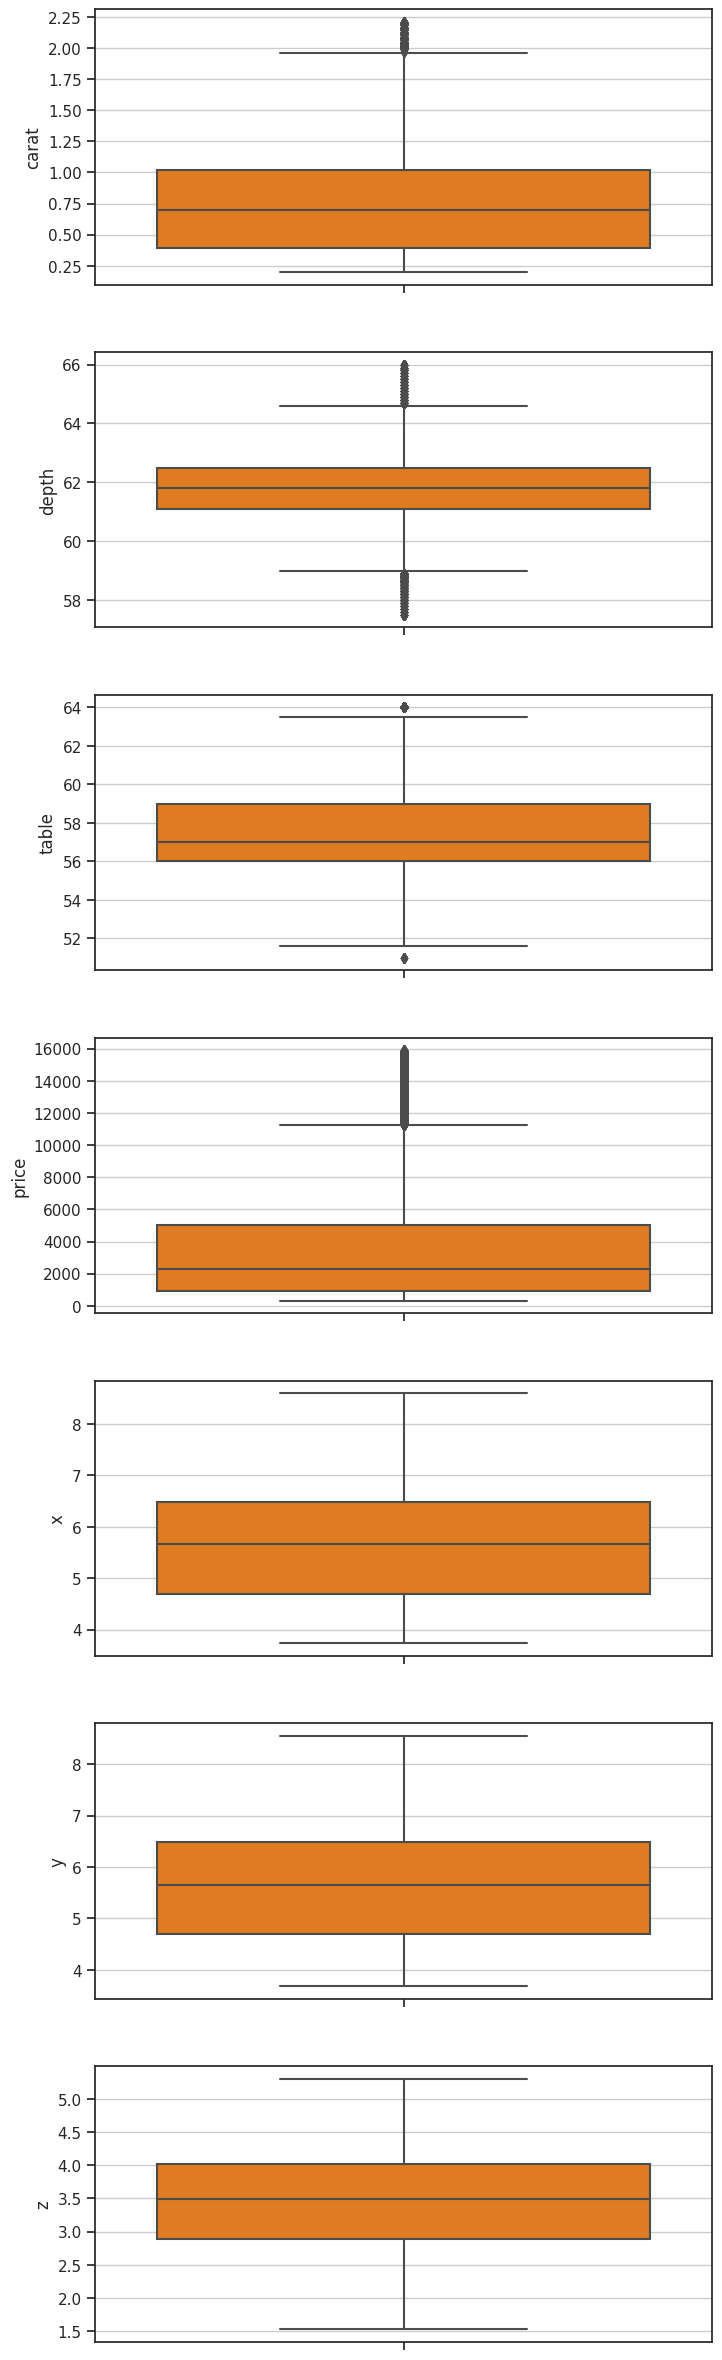

In [14]:
fig, axes = plt.subplots(7, 1, figsize=(8, 25))
plt.tight_layout(pad=4, w_pad=2, h_pad=2)

for i, variavel in enumerate(colunas_quantitativas):
    ax = sns.boxplot(
        y=X[variavel], 
        ax=axes[i],
        color=colors[2]
    ) 
    ax.grid(axis='y', linestyle='-')

plt.show()